In [1]:
import yaml
from yaml.loader import SafeLoader
from socket import gethostname
import numpy as np

print(gethostname())
# Open the file and load the file
with open('config.yml') as f:
    all_yaml = yaml.load(f, Loader=SafeLoader)
    if gethostname() in all_yaml.keys():
        config = all_yaml[gethostname()]
    else:
        config = all_yaml['default']
        
print(config)



dyn-10-109-63-143.wless.uoregon.edu
{'dropbox_data_dir': '/Users/benjaminsmith/Dropbox (University of Oregon)/UO-SAN Lab/Berkman Lab/Devaluation/analysis_files/data/'}


In [2]:
dropbox_data_dir = config['dropbox_data_dir']


# Introduction
This is a pre-registered analysis for measuring moderations of the intervention.

We'll cross-validate the intervention moderations.

For this analysis, we'll try to make predictions based on some synthetic data. we'll take wave 1 data and randomly mix in changes based on our predictors, then try to model how we would predict those things. Finally, we'll make the predictions.

# Load data

In [3]:
import pandas as pd

data_by_ppt_path = dropbox_data_dir + '/data_by_ppt.csv'
data_codebook_path = dropbox_data_dir + 'data_codebook.csv'




In [4]:
data_by_ppt = pd.read_csv(data_by_ppt_path)


In [5]:
data_codebook = pd.read_csv(data_codebook_path)

In [6]:
#find out which columns in data_by_ppt are missing from the codebook
data_by_ppt.columns.difference(data_codebook['VarName'])

Index([], dtype='object')

In [7]:

#copy our outcome measures, bf_1 and FFQ_1, into a new dataframe
data_by_ppt['bf_2'] = data_by_ppt.bf_1
#need to decide what sort of FFQ we want to use
data_by_ppt['cancer_promoting_minus_preventing_FFQ_1'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ
data_by_ppt['cancer_promoting_minus_preventing_FFQ_2'] = data_by_ppt.cancer_promoting_minus_preventing_FFQ

In [8]:
analysis_data  = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedPredictor,"VarName"]].copy()
outcome_measures = data_by_ppt.loc[:,data_codebook.loc[data_codebook.IsSelectedOutcomeMeasure,"VarName"]].copy()

In [9]:
na_values = pd.DataFrame(data_by_ppt.isna().sum())
na_values.columns = ['NA_Count']
na_values['prop_NA'] = na_values.NA_Count / data_by_ppt.shape[0]
data_codebook = data_codebook.merge(na_values, left_on='VarName', right_index=True)

In [10]:
data_codebook.to_csv(dropbox_data_dir + 'data_metadata.csv', index=False)

Need to count the number of valid and missing entries in each of our data predictors

## Converting data to numeric format

In [11]:
one_hot_vals = pd.get_dummies(analysis_data.birthsex_factor)
#there's only two variables here so we can convert this into a dummy variable
analysis_data.drop(columns=['birthsex_factor'], inplace=True)
one_hot_vals.columns = ['birthsex_factor_' + str(col) for col in one_hot_vals.columns]
analysis_data = analysis_data.join(one_hot_vals.iloc[:,1:])

In [12]:
analysis_data

,BSCS,EDM,BIS_11,PCS,RS,TRSQ,ACES_neglectful_parenting,ACES_abuse,ACES_sum,ACES_divorced_separated,...,zipcode_median_income_acs,household_income_per_person,SST_prop_successful_stops,SST_GRTmean,SST_SSD,SST_PostErrorSlowW1_mean,SST_mean_ssrt_0,ROC_Crave_Regulate_Minus_Look,WTP_unhealthy_minus_healthy,birthsex_factor_Male
0,2.538462,3.250,72,7.0,20.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5125,-0.312500,1
1,2.384615,1.750,89,9.0,22.0,63.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.440524,0
2,3.384615,2.500,63,9.0,18.0,57.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.500000,533.315052,284.375,0.058297,0.247061,-0.8000,-0.190476,0
3,3.076923,2.800,75,NaN,NaN,64.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.312500,498.167248,103.125,0.027730,0.446583,-0.8000,0.170363,0
4,3.307692,2.750,64,12.0,21.0,55.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.562500,626.507764,250.000,0.105660,0.369308,-1.5500,-0.494624,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,3.461538,4.000,58,18.0,17.0,54.0,0.0,1.0,3.0,1.0,...,-0.690347,1.768485,0.523438,NaN,NaN,NaN,0.357362,-0.0125,-1.008152,1
271,3.692308,3.875,54,17.0,13.0,55.0,2.0,2.0,5.0,0.0,...,-0.511475,-0.234851,0.492188,NaN,NaN,NaN,0.335849,-0.1500,-1.889247,1
272,3.461538,3.125,69,11.0,13.0,53.0,1.0,1.0,6.0,1.0,...,1.335248,0.099038,0.507812,NaN,NaN,NaN,0.273736,NaN,0.516129,1
273,2.846154,3.000,62,15.0,22.0,84.0,0.0,1.0,4.0,1.0,...,0.855379,-0.234851,0.479167,NaN,NaN,NaN,0.401098,-0.9875,-0.151210,0


# Missing data 

Apply missing data imputation to columns including cSES, ACES_sum, ses_aggregate, zipcode_median_income_acs, IMI, mcarthur social standing, based on demographic and self-report predictors.

In [13]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import linear_model

#which columns do we want to exclude? 
# 
# Probably we can include all the columns in the codebook which aren't predictors.
# I checked, and ACES, cSES, RTFS are the only columns over 20% missing, and I'm comfortable imputing those from other values.
# Sitautions we might wnat to avoid imputing are where missingness is correlated with the predictor itself
# that's the case for IPAQ probably, but we're avoiding IPAQ altogether for now.

#analysis_data_imputed = analysis_data.loc[:,['ACES_sum','cSES']].copy()
def get_data_for_imputation(analysis_data):
    analysis_data_imputed = analysis_data.copy()
    return(analysis_data_imputed)



In [14]:
#try a few methods of imputation and compare them.
#I tried a few. the default is BayesianRidge, but i found this didn't pick up on the linear relationship between ACES and cSES
#Ridge found the linear relationship, but also does some regularization which is probably useful for accuracy

imputation_methods = {
    
    'knn_3':KNNImputer(n_neighbors=3),
    'ridge_10':IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=10,max_iter=100),
    'knn_4':KNNImputer(n_neighbors=4),
    
    'knn_6':KNNImputer(n_neighbors=6),
    'ridge':IterativeImputer(estimator=linear_model.Ridge(),max_iter=100),
    'ridge_5':IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=5,max_iter=100),
    
    'bayesianridge_3':IterativeImputer(estimator=linear_model.BayesianRidge(),max_iter=100,n_nearest_features=3)
    
}


In [15]:


# for imp_label in imputation_methods.keys():
#     analysis_data_imputed = get_data_for_imputation(analysis_data)
#     print(imp_label)
#     imp = imputation_methods[imp_label]
#     #this dataset is already filtered for columns so we don't need to filter those further.
#     analysis_data_imputed = pd.DataFrame(imp.fit_transform(analysis_data_imputed), columns=analysis_data_imputed.columns)
#     imputed_datapoint = analysis_data.isna()
#     do_aces_cses_imputation_diagnostic(analysis_data_imputed, imputed_datapoint,imp_label)
    



Based on this experiment, I'm going for Ridge regression with 10 nearest features. The values it imputes are a compromise between simply using the nearest mean, which is conservative when using these values for prediction because it doesn't introduce erroneous variance, but isn't very informative, and then using all available information, which Ridge regression with an unlimited number of features would do. It's a tough choice between this and KNN, which doesn't assume normality. Overall I'm going with KNN, because it picks up on relationships between the two variables while not generating extreme values like KNN seems to do.

In [16]:
imputer = IterativeImputer(estimator=linear_model.Ridge(),n_nearest_features=10,max_iter=100,random_state=0)
analysis_data_imputed = get_data_for_imputation(analysis_data)

#this dataset is already filtered for columns so we don't need to filter those further.
analysis_data_imputed = pd.DataFrame(imputer.fit_transform(analysis_data_imputed), columns=analysis_data_imputed.columns)
imputed_datapoint = analysis_data.isna()
# do_aces_cses_imputation_diagnostic(analysis_data_imputed, imputed_datapoint,'ridge_10')


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


# Add synthetic data

## synthetic condition mediator

In [17]:
#set np random seed
np.random.seed(3161527)

In [18]:
group_names = ['ichi','ni','san']
#assign each row randomly to a group
group_assignments = np.random.choice(group_names,analysis_data_imputed.shape[0])



## synthetic outcome variables

Which variables will we test to predict? We need to select variables from the following groups:

 - self-report variables
 - demographic variables we'll test
 - summaries of neural activities from each of WTP, SST, and ROC
 - summaries of behavioral data from each of WTP, SST, and ROC




In [19]:
#set np random seed
np.random.seed(3161526)

In [20]:

#rename columns to what we'll expect once we have the wave 2 data in
outcome_measures.rename(columns={
    'cancer_promoting_minus_preventing_FFQ':'cancer_promoting_minus_preventing_FFQ_w1','FFQ_v2_Mean_Energy':'FFQ_v2_Mean_Energy_w1'}, inplace=True)

#add a random drift of 1.0 to each of these...
def add_rnd_drift(datacol):
    return(datacol + np.random.normal(0,np.std(datacol)/2,len(datacol)))


outcome_measures['bf_2']=add_rnd_drift(outcome_measures.bf_1)
outcome_measures['cancer_promoting_minus_preventing_FFQ_w2']=add_rnd_drift(outcome_measures.cancer_promoting_minus_preventing_FFQ_w1)
outcome_measures['FFQ_v2_Mean_Energy_w2']=add_rnd_drift(outcome_measures.FFQ_v2_Mean_Energy_w1)

## add synthetic primary and interaction effects

In [21]:
#create a normed version of the predictor array
#normalize each column to have mean 0 and std 1
predictors_normed = analysis_data_imputed.copy()
for col in predictors_normed.columns:
    predictors_normed[col] = (predictors_normed[col] - np.mean(predictors_normed[col]))/np.std(predictors_normed[col])




#sample effect size from a normal distribution for each predictor
#sample from a normal distribution with mean 0 and std 0.1
#then add to the predictor value
#for each group, calculate main effect
groups = np.unique(group_assignments)[1:]
print(groups)
group_main_effects = np.random.normal(0,1,groups.shape[0])
print(group_main_effects)


#apply the main effect. note that the first group will not have a main effect
for i,group in enumerate(groups):
    for om in ['bf_2','cancer_promoting_minus_preventing_FFQ_w2','FFQ_v2_Mean_Energy_w2']:
        om_mean = np.nanmean(outcome_measures[om])
        om_sd = np.nanstd(outcome_measures[om])
        outcome_measures[om] = outcome_measures[om] + (group_assignments==group)*group_main_effects[i]

interaction_effects_list = []
print(group_assignments)
#apply the interaction effect
for i,group in enumerate(groups):
    print(group)
    #generate interaction effect for group
    predictor_interaction_effects = np.random.normal(0,0.5,predictors_normed.shape[1])
    #just add an effect of 1 to the first item only.
    # predictor_interaction_effects = [0]*(predictors_normed.shape[1])
    # predictor_interaction_effects[i] = 0.5
    # print(predictor_interaction_effects[0:10])
    #multiply the predictor interaction effect by the predictor values
    predictor_interaction_values = predictors_normed * predictor_interaction_effects
    # print(predictor_interaction_values.iloc[0:10,0:5])
    outcome_zscore_change = (group_assignments==group)*np.sum(predictor_interaction_values,axis=1)
    # print("zscore:")
    # print(outcome_zscore_change.head())
    # #add that to the outcome measures
    for om in ['bf_2','cancer_promoting_minus_preventing_FFQ_w2','FFQ_v2_Mean_Energy_w2']:
        #take mean and sd of non-nan values
        print(om)
        om_mean = np.nanmean(outcome_measures[om])
        om_sd = np.nanstd(outcome_measures[om])
        # print(om_mean)
        # print(om_sd)
        
        outcome_measures.loc[group_assignments==group,om] = outcome_measures.loc[group_assignments==group,om] + outcome_zscore_change[group_assignments==group]*om_sd

    
    interaction_effects_list.append(
        pd.DataFrame(
        {'group':[group]*predictors_normed.shape[1],
        'predictor':predictors_normed.columns,
         'interaction_effect':predictor_interaction_effects})
    )


interaction_effect_df = pd.concat(interaction_effects_list)

interaction_effect_abs = np.abs(interaction_effect_df.interaction_effect)
#sort by absolute value of interaction effect
interaction_effect_df['interaction_effect_abs'] = interaction_effect_abs
interaction_effect_df = interaction_effect_df.sort_values('interaction_effect_abs',ascending=False)
interaction_effect_df = interaction_effect_df.drop('interaction_effect_abs',axis=1)

['ni' 'san']
[-0.37008184 -1.06951747]
['san' 'san' 'ni' 'ichi' 'san' 'san' 'ichi' 'san' 'san' 'san' 'ni' 'ichi'
 'ichi' 'ichi' 'ichi' 'san' 'san' 'san' 'ichi' 'ichi' 'san' 'san' 'ni'
 'ni' 'ni' 'ni' 'ni' 'ni' 'ni' 'san' 'ni' 'san' 'ni' 'ichi' 'ni' 'san'
 'ni' 'ichi' 'san' 'ni' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ni' 'ni'
 'san' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ichi' 'ni' 'ni' 'ni' 'ichi' 'san'
 'ni' 'ni' 'ichi' 'ni' 'ichi' 'san' 'ni' 'ni' 'ni' 'san' 'ichi' 'ni' 'san'
 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'ichi' 'san' 'ichi' 'san' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'san' 'ni' 'san' 'ni' 'ichi' 'san' 'san' 'san' 'ichi'
 'ni' 'san' 'ichi' 'ichi' 'san' 'ni' 'ichi' 'san' 'ni' 'ni' 'san' 'ni'
 'ichi' 'ni' 'ichi' 'ichi' 'ni' 'ichi' 'ichi' 'ichi' 'san' 'san' 'ichi'
 'ni' 'ni' 'ichi' 'ni' 'ni' 'ichi' 'ichi' 'san' 'san' 'ni' 'ichi' 'ni'
 'ichi' 'ichi' 'san' 'ichi' 'ni' 'san' 'san' 'ni' 'ni' 'san' 'san' 'san'
 'ichi' 'san' 'ni' 'san' 'ichi' 'ichi' 'ichi' 'ni' 'san' 'ni' 'ni' 'ni'
 'ichi' 'ni' 'ichi'

In [22]:
interaction_effect_df[0:10]

,group,predictor,interaction_effect
36,san,NCS_abstract_thinking,-1.584458
71,ni,SST_PostErrorSlowW1_mean,-1.330387
53,ni,TESQ_E_avoidance_of_temptations,-1.254394
48,san,RTFS_factor_2,1.177560
44,ni,RMQ_lie,1.176132
46,san,RMQ_locomotion,1.146603
73,ni,ROC_Crave_Regulate_Minus_Look,1.063837
28,san,NCS_thinking_not_fun,1.020835
27,san,NCS_avoid_depth,-0.986660
12,san,BFI_conscientiousness,-0.977844


# Further preprocessing

These steps are performed on the data regardless of whether we are using synthetic data or real data.

## Set up outcome measures and group assignment one-hot





In [23]:
outcome_measures['d_bf'] = outcome_measures.bf_2 - outcome_measures.bf_1
outcome_measures['d_cancer_promoting_minus_preventing_FFQ'] = outcome_measures.cancer_promoting_minus_preventing_FFQ_w2 - outcome_measures.cancer_promoting_minus_preventing_FFQ_w1
outcome_measures['d_FFQ_v2_Mean_Energy'] = outcome_measures.cancer_promoting_minus_preventing_FFQ_w2 - outcome_measures.cancer_promoting_minus_preventing_FFQ_w1



In [24]:
group_assignment_onehots = pd.get_dummies(group_assignments).loc[:,['ni','san']]

# Use cross-validation to find the effects

Here we want to know: which variables are correlated with the outcome measures? A naive way is to use ridge regression to predict the outcome measures from the predictors, with every predictor crossed with a one-hot of the group assignment. 

To do this, unlike in R where we'd write out an equation and let the system take care of it, here, I'll build the interactions manually.

## Run a basic regression to ensure we can detect effects

In [25]:

predictor_data = analysis_data_imputed
predictor_data_columns = predictor_data.columns
predictor_data_array = np.array(predictor_data)
predictor_data = pd.concat([predictor_data,group_assignment_onehots],axis=1)
for group_name in group_assignment_onehots.columns:

    #do a matrix multiplication of the group assignment onehot with the analysis data
    #repeat the group assignment onehot for each column in the analysis data
    
    interaction_array = predictor_data_array*np.array(group_assignment_onehots[group_name],ndmin=2).T
    interaction_df = pd.DataFrame(interaction_array, columns= [(c + '*'+group_name) for c in predictor_data_columns])
    print(interaction_df.shape)
    #then add the result to the analysis data
    predictor_data = pd.concat([predictor_data,interaction_df],axis=1)

    



(275, 76)
(275, 76)


In [26]:
predictor_data.loc[:,['BSCS','EDM','BSCS*ni','BSCS*san','EDM*ni','EDM*san']]

,BSCS,EDM,BSCS*ni,BSCS*san,EDM*ni,EDM*san
0,2.538462,3.250,0.000000,2.538462,0.0,3.250
1,2.384615,1.750,0.000000,2.384615,0.0,1.750
2,3.384615,2.500,3.384615,0.000000,2.5,0.000
3,3.076923,2.800,0.000000,0.000000,0.0,0.000
4,3.307692,2.750,0.000000,3.307692,0.0,2.750
...,...,...,...,...,...,...
270,3.461538,4.000,3.461538,0.000000,4.0,0.000
271,3.692308,3.875,0.000000,0.000000,0.0,0.000
272,3.461538,3.125,0.000000,3.461538,0.0,3.125
273,2.846154,3.000,0.000000,2.846154,0.0,3.000


In [27]:
# #for group ni, plot the relationship bewtween BSCS*ni and the outcome measure in matplotlib scatter plot


# #scatterplot
# from matplotlib import pyplot as plt



# for predictor in ['BSCS','EDM']:

#     plt.figure()
#     plt.scatter(predictor_data[predictor],outcome_measures['d_bf'],c=group_assignments==group_name)
#     plt.xlabel(predictor)
#     plt.ylabel('d_bf')
#     plt.title(predictor+' vs d_bf')

#     for group_name in group_assignment_onehots.columns:
#         plt.figure()
#         plt.scatter(predictor_data[predictor + '*'+group_name],outcome_measures['d_bf'],c=group_assignments==group_name)
#         plt.xlabel(predictor + '*'+group_name)
#         plt.ylabel('d_bf')
#         plt.title(predictor + '*'+group_name+' vs d_bf')
    

In [28]:
#remove any NA values for this outcome measure in both the predictor data and the outcome data
outcome_nas = outcome_measures['d_bf'].isna()

outcome_measures_nona = outcome_measures.loc[~outcome_nas,:]
predictor_data_nona = predictor_data.loc[~outcome_nas,:]


Now do ridge regression to hopefully identify any predictors of outcome measures.

In [29]:
import statsmodels.api as sm

predictor_data_nona = sm.add_constant(predictor_data_nona)
model = sm.OLS(outcome_measures_nona['d_bf'], predictor_data_nona.loc[:,['const','ni','san','BSCS','EDM','BSCS*ni','BSCS*san','EDM*ni','EDM*san']]).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   d_bf   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     3.456
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           0.000837
Time:                        09:52:45   Log-Likelihood:                -1430.2
No. Observations:                 270   AIC:                             2878.
Df Residuals:                     261   BIC:                             2911.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7621     32.832      0.054      0.957     -62.886      66.411
ni           -69.0336     46.521     -1.484      0.139    -160.638      22.571
san          160.8357     47.709      3.371      0.001      66.892     254.779
BSCS          -1.3075      9.824     -0.133      0.894     -20.653      18.038
EDM            0.6650      7.423      0.090      0.929     -13.951      15.281
BSCS*ni       14.4950     14.576      0.994      0.321     -14.207      43.196
BSCS*san     -47.3740     15.090     -3.140      0.002     -77.087     -17.661
EDM*ni         7.4771     10.681      0.700      0.485     -13.555      28.509
EDM*san       -1.7369     10.610     -0.164      0.870     -22.629      19.155
==============================================================================
Omnibus:                       33.343   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.123
Skew:                          -0.222   Prob(JB):                     1.27e-39
Kurtosis:                       6.965   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
import statsmodels.api as sm

predictor_data_nona = sm.add_constant(predictor_data_nona)
model = sm.OLS(outcome_measures_nona['d_bf'], predictor_data_nona).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   d_bf   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     204.4
Date:                Mon, 20 Mar 2023   Prob (F-statistic):           9.33e-38
Time:                        09:52:46   Log-Likelihood:                -485.90
No. Observations:                 270   AIC:                             1434.
Df Residuals:                      39   BIC:                             2265.
Df Model:                         230                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                              -30.0280     25.767     -1.165      0.251     -82.146      22.090
BSCS                                                -2.3243      3.470     -0.670      0.507      -9.344       4.695
EDM                                                 -2.3868      2.461     -0.970      0.338      -7.364       2.591
BIS_11                                               0.1871      0.182      1.026      0.311      -0.182       0.556
PCS                                                 -0.3929      0.413     -0.952      0.347      -1.228       0.442
RS                                                  -0.1684      0.242     -0.697      0.490      -0.657       0.320
TRSQ                                                 0.0532      0.130      0.407      0.686      -0.211       0.317
ACES_neglectful_parenting                          -79.5500    197.870     -0.402      0.690    -479.781     320.681
ACES_abuse                                         -76.1594    198.014     -0.385      0.703    -476.680     324.361
ACES_sum                                            76.7746    198.057      0.388      0.700    -323.835     477.384
ACES_divorced_separated                            -74.3117    198.077     -0.375      0.710    -474.959     326.336
ACES_household_dysfunction                         -76.1972    198.459     -0.384      0.703    -477.618     325.224
BFI_agreeableness                                    0.1145      0.248      0.461      0.647      -0.388       0.617
BFI_conscientiousness                                0.6372      0.329      1.937      0.060      -0.028       1.303
BFI_extraversion                                    -0.4868      0.224     -2.171      0.036      -0.940      -0.033
BFI_neuroticism                                      0.2702      0.256      1.056      0.298      -0.248       0.788
BFI_openness                                        -0.0380      0.223     -0.171      0.865      -0.488       0.412
DEMO_mcarthur_social_standing                        0.0132      0.455      0.029      0.977      -0.907       0.934
IMI_effort_importance                                2.0814      1.759      1.183      0.244      -1.476       5.639
IMI_value_usefulness                                -1.3005      2.167     -0.600      0.552      -5.683       3.082
IMI_interest_enjoyment                               1.9611      1.225      1.600      0.118      -0.517       4.440
IMI_perceived_choice                                 0.4931      1.248      0.395      0.695      -2.031       3.017
IMI_perceived_competence                             0.9202      2.008      0.458      0.649      -3.142       4.982
NCS_get_job_done                         

In [31]:
#create a ridge regression
primary_regression = linear_model.Ridge(fit_intercept=True, alpha=0.5)

#fit the model
model_fit = primary_regression.fit(predictor_data_nona,outcome_measures_nona['d_bf'])

In [32]:
#view the coefficients
ridge_results = pd.DataFrame({
    'predictor': predictor_data_nona.columns,
    'coef': model_fit.coef_
    #'std_err': np.sqrt(np.diag(model_fit.coef_cov_)),
    #'pval': 2*(1-stats.t.cdf(np.abs(model_fit.coef_/np.sqrt(np.diag(model_fit.coef_cov_))),df=predictor_data_nona.shape[0]-predictor_data_nona.shape[1]))
})

ridge_results['coef_abs'] = np.abs(ridge_results.coef)
ridge_results = ridge_results.sort_values('coef_abs',ascending=False)

In [33]:
ridge_results[0:10]

,predictor,coef,coef_abs
191,NCS_abstract_thinking*san,-33.169082,33.169082
201,RMQ_locomotion*san,29.427318,29.427318
183,NCS_thinking_not_fun*san,28.620279,28.620279
217,cancer_promoting_minus_preventing_liked_FCI*san,26.840080,26.840080
230,birthsex_factor_Male*san,26.797997,26.797997
150,SST_PostErrorSlowW1_mean*ni,-25.096372,25.096372
196,PLAN_cognitive_strategies*san,-24.681183,24.681183
198,PLAN_temporal_orientation*san,-23.379661,23.379661
182,NCS_avoid_depth*san,-21.791386,21.791386
152,ROC_Crave_Regulate_Minus_Look*ni,19.030120,19.030120


In [34]:
interaction_effect_df[0:10]

,group,predictor,interaction_effect
36,san,NCS_abstract_thinking,-1.584458
71,ni,SST_PostErrorSlowW1_mean,-1.330387
53,ni,TESQ_E_avoidance_of_temptations,-1.254394
48,san,RTFS_factor_2,1.177560
44,ni,RMQ_lie,1.176132
46,san,RMQ_locomotion,1.146603
73,ni,ROC_Crave_Regulate_Minus_Look,1.063837
28,san,NCS_thinking_not_fun,1.020835
27,san,NCS_avoid_depth,-0.986660
12,san,BFI_conscientiousness,-0.977844


In [35]:
#create a ridge regression
primary_regression = linear_model.Ridge(fit_intercept=True, alpha=1.0)

#fit the model
model_fit = primary_regression.fit(predictor_data_nona,outcome_measures_nona['d_bf'])

In [36]:
#view the coefficients
ridge_results = pd.DataFrame({
    'predictor': predictor_data_nona.columns,
    'coef': model_fit.coef_
    #'std_err': np.sqrt(np.diag(model_fit.coef_cov_)),
    #'pval': 2*(1-stats.t.cdf(np.abs(model_fit.coef_/np.sqrt(np.diag(model_fit.coef_cov_))),df=predictor_data_nona.shape[0]-predictor_data_nona.shape[1]))
})

ridge_results['coef_abs'] = np.abs(ridge_results.coef)
ridge_results = ridge_results.sort_values('coef_abs',ascending=False)

In [37]:
ridge_results

,predictor,coef,coef_abs
191,NCS_abstract_thinking*san,-31.090097,31.090097
183,NCS_thinking_not_fun*san,25.410603,25.410603
201,RMQ_locomotion*san,24.357201,24.357201
230,birthsex_factor_Male*san,23.514386,23.514386
196,PLAN_cognitive_strategies*san,-21.449658,21.449658
...,...,...,...
3,BIS_11,-0.010695,0.010695
223,SST_prop_successful_stops*san,0.006775,0.006775
71,SST_SSD,0.006677,0.006677
5,RS,-0.000176,0.000176


## optimizing ridge regression using nested cross-validation

In [38]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


np.linspace(-3,1,(1--3)*2)

## Running models with GridSearchCV

In [73]:
pipeline_estimator_name = 'estimator'
def get_estimator_with_preprocessing(estimator):
    return(Pipeline([('scaler',StandardScaler()),(pipeline_estimator_name,estimator)]))

def get_param_grid_with_preprocessing(param_grid):
    #prepend "estimator__" to each parameter name in param_grid
    return({(pipeline_estimator_name + '__'+k):v for k,v in param_grid.items()})




In [ ]:
alpha_10pow_lower = 6
alpha_10pow_upper = -1
alpha_increments=1
alpha_range = np.power(10,np.linspace(-alpha_10pow_lower,alpha_10pow_upper,(alpha_10pow_lower+alpha_10pow_upper)*alpha_increments+1))
elasticnet_parameters = {
    'alpha':alpha_range,
    'l1_ratio': [0.1,0.3,0.5,0.9,0.99],#np.linspace(0.1,0.9,4+1),
    'max_iter': [10000]
    }
print(elasticnet_parameters)
elasticnet_model = linear_model.ElasticNet()



elasticnet_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(elasticnet_model), param_grid = get_param_grid_with_preprocessing(elasticnet_parameters), cv=10,scoring='neg_mean_absolute_error')
elasticnet_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])


In [43]:

ridge_parameters = {'alpha':alpha_range}
ridge_model = linear_model.Ridge()
print(ridge_parameters)
ridge_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(ridge_model), param_grid = get_param_grid_with_preprocessing(ridge_parameters), cv=10,scoring='neg_mean_absolute_error')
ridge_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])
sorted(ridge_grid_search_cv.cv_results_.keys())



{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_estimator__alpha',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'split6_test_score',
 'split7_test_score',
 'split8_test_score',
 'split9_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [46]:
lasso_parameters = {'alpha':alpha_range}
lasso_model = linear_model.Lasso()
print(lasso_parameters)
lasso_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(lasso_model), param_grid = get_param_grid_with_preprocessing(lasso_parameters), cv=10,scoring='neg_mean_absolute_error')
lasso_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])



{'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])}


/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e+03, tolerance: 5.851e+01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e+03, tolerance: 6.682e+01
  model = cd_fast.enet_coordinate_descent(
/Users/benjaminsmith/opt/anaconda3/envs/dataanalysis3_10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase 

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', Lasso())]),
             param_grid={'estimator__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])},
             scoring='neg_mean_absolute_error')

In [47]:
#KNeighborsRegressor
knn_parameters = {'n_neighbors':np.unique(np.round(np.power(10,np.linspace(0,2,2*5+1)))).astype(int)}
knn_model = KNeighborsRegressor()
print(knn_parameters)
knn_grid_search_cv = GridSearchCV(estimator=get_estimator_with_preprocessing(knn_model), param_grid = get_param_grid_with_preprocessing(knn_parameters), cv=10,scoring='neg_mean_absolute_error')
knn_grid_search_cv.fit(predictor_data_nona,outcome_measures_nona['d_bf'])


{'n_neighbors': array([  1,   2,   3,   4,   6,  10,  16,  25,  40,  63, 100])}


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', KNeighborsRegressor())]),
             param_grid={'estimator__n_neighbors': array([  1,   2,   3,   4,   6,  10,  16,  25,  40,  63, 100])},
             scoring='neg_mean_absolute_error')

## Display models

In [81]:
def extract_estimator_params_from_gridsearch(param_dict):
    dict_list = [{k.replace(pipeline_estimator_name + "__",""):param_dict[k]} for k in param_dict.keys() if k.startswith(pipeline_estimator_name)]
    #convert the dict_list into a dict
    return({k:v for d in dict_list for k,v in d.items()})

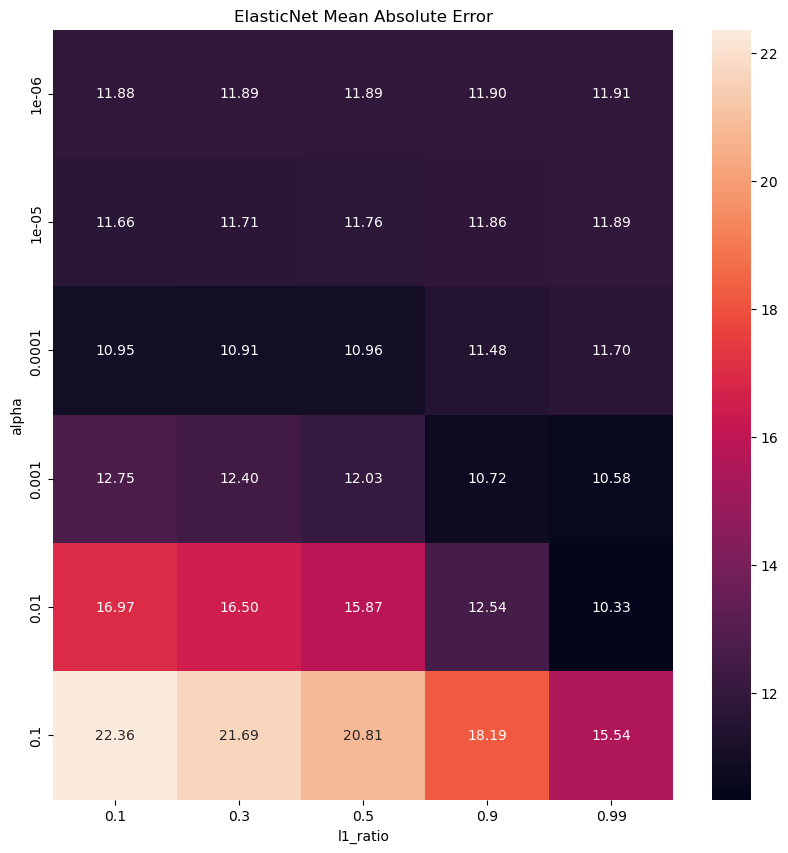

In [84]:
#plot a heatmap of cv_results_ for the param alpha and l1_ratio using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#convert the cv_results_ to a dataframe
elasticnet_cv_results_df = pd.DataFrame(elasticnet_grid_search_cv.cv_results_)
estimator_params = elasticnet_cv_results_df.params.apply(lambda x: extract_estimator_params_from_gridsearch(x))
elasticnet_cv_results_df['alpha'] = estimator_params.apply(lambda x: x['alpha'])
elasticnet_cv_results_df['l1_ratio'] = estimator_params.apply(lambda x: x['l1_ratio'])
elasticnet_cv_results_df['mean_test_score'] = elasticnet_cv_results_df.mean_test_score*-1

#plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(elasticnet_cv_results_df.pivot(index='alpha',columns='l1_ratio',values='mean_test_score'),annot=True,fmt='.2f')
plt.title('ElasticNet Mean Absolute Error')
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.show()

Text(0.5, 1.0, 'KNN Mean Absolute Error')

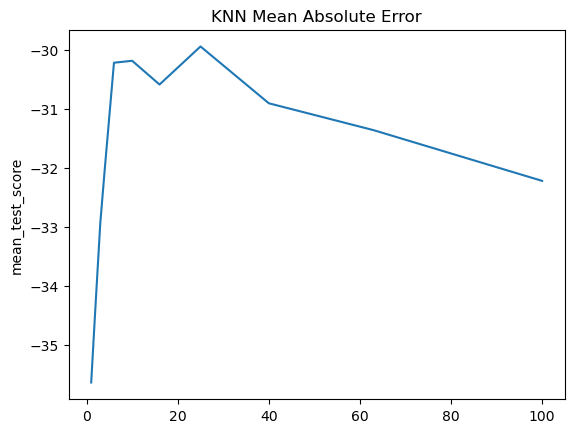

In [91]:
#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot([extract_estimator_params_from_gridsearch(p)['n_neighbors'] for p in knn_grid_search_cv.cv_results_['params']],knn_grid_search_cv.cv_results_['mean_test_score'])
plt.ylabel('mean_test_score')
plt.title('KNN Mean Absolute Error')


Text(0.5, 1.0, 'Lasso Mean Absolute Error')

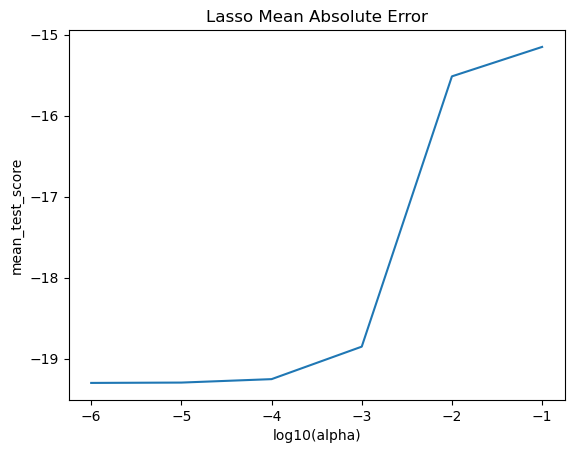

In [89]:


#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.log10([extract_estimator_params_from_gridsearch(p)['alpha'] for p in lasso_grid_search_cv.cv_results_['params']]),lasso_grid_search_cv.cv_results_['mean_test_score'])
plt.xlabel('log10(alpha)')
plt.ylabel('mean_test_score')
plt.title('Lasso Mean Absolute Error')


Text(0.5, 1.0, 'Ridge Mean Absolute Error')

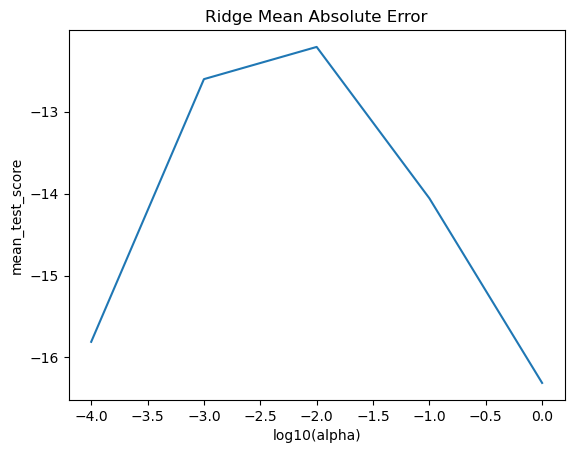

In [ ]:
#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.log10([p['alpha'] for p in ridge_grid_search_cv.cv_results_['params']]),ridge_grid_search_cv.cv_results_['mean_test_score'])
plt.xlabel('log10(alpha)')
plt.ylabel('mean_test_score')
plt.title('Ridge Mean Absolute Error')


Text(0.5, 1.0, 'Ridge Mean Absolute Error')

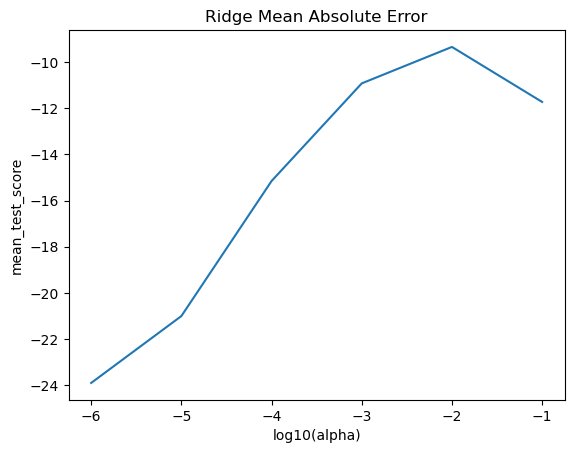

In [92]:
#graph alpha and mean_test_score
#use the log10 of alpha but label the x-axis with alpha
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.log10([extract_estimator_params_from_gridsearch(p)['alpha'] for p in ridge_grid_search_cv.cv_results_['params']]),ridge_grid_search_cv.cv_results_['mean_test_score'])
plt.xlabel('log10(alpha)')
plt.ylabel('mean_test_score')
plt.title('Ridge Mean Absolute Error')


## pick the best model

In [104]:
all_cv_results = [ridge_grid_search_cv, lasso_grid_search_cv, elasticnet_grid_search_cv, knn_grid_search_cv]

#create a dataframe with the best parameters, best mean_test_score, and name of the model

best_params_df = pd.DataFrame({
    'model': [cv_result.estimator for cv_result in all_cv_results],
    'model_name': [cv_result.estimator.__class__.__name__ for cv_result in all_cv_results],
    'best_params': [extract_estimator_params_from_gridsearch(cv_result.best_params_) for cv_result in all_cv_results],
    'best_score': [cv_result.best_score_ for cv_result in all_cv_results],
    'best_raw_params' : [cv_result.best_params_ for cv_result in all_cv_results]
    })




In [105]:
from sklearn.base import clone

best_params_df = best_params_df.sort_values('best_score',ascending=False).reset_index(drop=True)

best_model = clone(best_params_df['model'][0])
best_model_params = best_params_df['best_raw_params'][0]
best_model.set_params(**best_model_params)

Pipeline(steps=[('scaler', StandardScaler()), ('estimator', Ridge(alpha=0.01))])

To do next:

 - normalize the dataset, using a pipeline so that normalizing is only done on the training set, with the same transformation then done on the test set. 
   - DONE
 - after that, we'll have a reasonable pipeline for model selection, but we then need to embed that in a nested CV for estimating generalization.
 - Need to deal with the 

Ridge regression seems to perform best so far, on this dataset. If the Ridge regression performs best on the actual dataset, we would potentially choose it. But we might want to rule it out from the start because it doesn't entirely eliminate variables that aren't predictive. Note that the actual, final dataset might be quite different and there's no real reason to think that it will respond in the same wya. In particular, it might choose an entirely different model. we should also ensure the grid-search has a range of params that is wider than the range we specialized on here.